### Ca/ATP coordinated TNFa release in microglia
Largely based on Hide, I., Tanaka, M., Inoue, A., Nakajima, K., Kohsaka, S., Inoue, K., & Nakata, Y. (2000). Extracellular ATP triggers tumor necrosis factor-alpha release from rat microglia. Journal of Neurochemistry, 75(3), 965–972. https://doi.org/10.1046/j.1471-4159.2000.0750965.x

Key factors from paper: 
- $\Delta Ca$ and TNFa release are similarly correlated with ATP, following 1 hr incubation (Figs 1B, 3B)
- $\Delta Ca$ transient is ATP dose and time dependent 
- Signal mediated through P2X7??
- ATP incubation increases TNFa mRNA ratio from 2 to 10 
- Extracellular Ca chelation substantially reduces TNFa release 
- p38/ERK inhibition strongly reduce TNFa release, ATP required, not Ca 
- Provides reference that NFAT responsible for TNFa transcription (verify)
- Suggests p38 operates post-transcription



Model assumptions 
- 'Released' BDNF depends on three terms: rTranscription, rTranslation, rRelease
- Ca-dependent NFAT activation drives rTranscription
- X-dependent (unknown substrate) p38/ERK increase rTranslate
- ATP-dependent P2X(4/7?) activation promotes Ca/X entry 


In [2]:
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

In [85]:
def dTNFdt_basic(y,t,rTranscribe, rTranslation, rDegrade,rRelease):
    transcribedTNF, translatedTNF,releasedTNF = y

    dtranscribedTNF_dt = rTranscribe - transcribedTNF*rTranslation
    dtranslatedTNF_dt =  transcribedTNF*rTranslation - translatedTNF*(rRelease+rDegrade)
    dreleasedTNF_dt =    translatedTNF*rRelease
    
    dydt = [dtranscribedTNF_dt,dtranslatedTNF_dt,dreleasedTNF_dt]
    return dydt



#### Steady state conditions

In [86]:
ts = np.linspace(0,10,100)

rTranscribe = 0.1 # [nM/s]
rTranslation=0.05 # [1/s] , 
rRelease = 0.00 # [1/s]
rDegrade = 0.075

# from steady state 
transcribedTNF=rTranscribe/rTranslation # [nM/cell]
translatedTNF=transcribedTNF*rTranslation/rDegrade  # [nM/cell]
releasedTNF=  0.  # [nm/cell]


y0s = [transcribedTNF, translatedTNF,releasedTNF]


In [87]:
ys = odeint(dTNFdt_basic,y0s,ts,args=(rTranscribe, rTranslation, rDegrade,rRelease))
print np.shape(ys)

(100, 3)


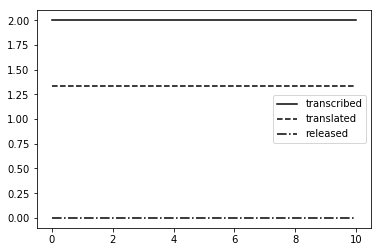

In [88]:
plt.plot(ts, ys[:,0],'k',label="transcribed")
plt.plot(ts, ys[:,1],'k--',label="translated")
plt.plot(ts, ys[:,2],'k-.',label="released")
plt.legend(loc=0)


### Add Ca dependence of release

In [313]:
def dTNFdt_CaRelease(y,t,rTranscribe, rTranslation, rDegrade,Ca_basal,Ca_active):
    transcribedTNF, translatedTNF,releasedTNF = y

    if t>5:
        Ca_t = Ca_active
    else:
        Ca_t = Ca_basal
        
    rRelease = calc_rRelease(Ca_t)
    
    dtranscribedTNF_dt = rTranscribe - transcribedTNF*rTranslation
    dtranslatedTNF_dt =  transcribedTNF*rTranslation - translatedTNF*(rRelease+rDegrade)
    #dtranslatedTNF_dt =    -translatedTNF*rRelease
    dreleasedTNF_dt =    translatedTNF*rRelease
    
    dydt = [dtranscribedTNF_dt,dtranslatedTNF_dt,dreleasedTNF_dt]
    return dydt

def calc_rRelease(Ca=1e-7,KD=1e-6,n=3,rReleaseBasal=1.):
    return rReleaseBasal/(1 + (KD/Ca)**n) 
    

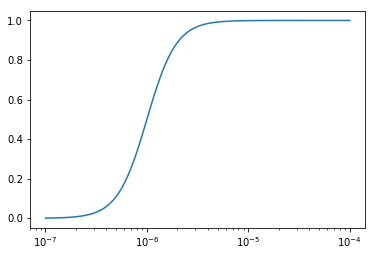

In [314]:
cas = 10**np.linspace(-7,-4,100)
plt.plot(cas,calc_rRelease(cas))
plt.xscale('log')

In [305]:
rTranscribe = 0.1 # [nM/s]
rTranslation=0.025 # [1/s] , 
rDegrade = 0.075


# Verify that we deplete translated TNF pools in a Ca dependent fashion 
#rTranscribe = 0.0 # [nM/s]
#rTranslation=0.00 # [1/s] , 
#rDegrade = 0.00

# from steady state
if rTranslation>0.:
    transcribedTNF=rTranscribe/rTranslation # [nM/cell]
else: 
    transcribedTNF=1. 
if rDegrade>0. and rTranslation>0. :
    translatedTNF=transcribedTNF*rTranslation/rDegrade  # [nM/cell]
else:
    translatedTNF = 0.5
releasedTNF=  0.  # [nm/cell]

ts = np.linspace(0,10,10000)


Ca_basal = 1e-7
Ca_active= 1e-6
y0s = [transcribedTNF, translatedTNF,releasedTNF]
ys = odeint(dTNFdt_CaRelease,y0s,ts,
            args=(rTranscribe, rTranslation, rDegrade,Ca_basal,Ca_active))
print np.shape(ys)

(10000, 3)


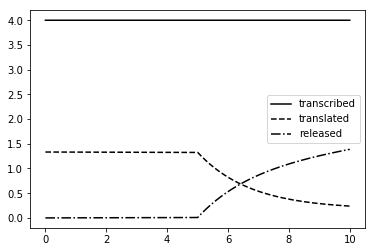

In [306]:


plt.plot(ts, ys[:,0],'k',label="transcribed")
plt.plot(ts, ys[:,1],'k--',label="translated")
plt.plot(ts, ys[:,2],'k-.',label="released")
plt.legend(loc=0)

#### Add ATP dependent p38/ERK activation w subsequent translation

In [324]:
def dTNFdt_CaRelease_p38ERK(y,t,
    rTranscribe, rDegrade,
    Ca_basal,Ca_active,
    X_basal, X_active):
    transcribedTNF, translatedTNF,releasedTNF,activep38ERK = y

    ### Ca-dependent TNF release 
    if t>5:
        Ca_t = Ca_active
    else:
        Ca_t = Ca_basal
    rReleaseBasal = 0.15    
    rRelease = calc_rRelease(Ca_t,rReleaseBasal = rReleaseBasal)
    
    ### X-dependent p38/ERK activation 
    if t>5:
        X_t = X_active
    else:
        X_t = X_basal
    rp38ERKactication = calc_p38ERKactivation(X_t)

    ### activated p38-dependent TNF transcription     
    rTranslation = calc_rTranslation(activep38ERK) 
    
    ### TNF
    dtranscribedTNF_dt = rTranscribe - transcribedTNF*rTranslation
    dtranslatedTNF_dt =  transcribedTNF*rTranslation - translatedTNF*(rRelease+rDegrade)
    dreleasedTNF_dt =    translatedTNF*rRelease
    
    ### p38/ERK active
    p38T = 3.
    kInactive = 30. * calc_p38ERKactivation(X_basal)
    dactivep38ERK_dt = rp38ERKactication*(p38T - activep38ERK) - kInactive*activep38ERK
    
    dydt = [dtranscribedTNF_dt,dtranslatedTNF_dt,dreleasedTNF_dt,dactivep38ERK_dt]
    return dydt

def calc_p38ERKactivation(X=1e-3,KD=3e-3,n=3):
    rBase = 1. # [nM/s]
    return rBase/(1 + (KD/X)**n) 

def calc_rTranslation(pp38ERK=0.1,KD=1.,n=2):
    rBase = 1. # [nM/s]
    return rBase/(1 + (KD/pp38ERK)**n) 

In [325]:
Ca_basal = 1e-7
Ca_active= 1e-5
X_basal = 1e-3
X_active= 5e-3
rTranscribe=0.056
rDegrade = 0.025

activep38ERK = 0.1
y0s = [transcribedTNF, translatedTNF,releasedTNF,activep38ERK]
ys = odeint(dTNFdt_CaRelease_p38ERK,y0s,ts,
            args=(rTranscribe, rDegrade,Ca_basal,Ca_active,X_basal,X_active))
print np.shape(ys)

(10000, 4)


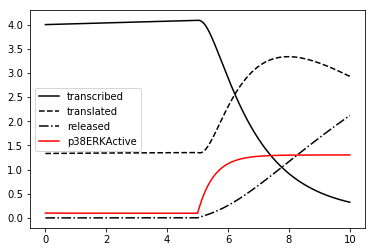

In [326]:

plt.plot(ts, ys[:,0],'k',label="transcribed")
plt.plot(ts, ys[:,1],'k--',label="translated")
plt.plot(ts, ys[:,2],'k-.',label="released")
plt.plot(ts, ys[:,3],'r',label="p38ERKActive")
plt.legend(loc=0)

#### Add P2X activation 

In [490]:
def dTNFdt_CaRelease_p38ERK_P2X(y,t,
    rTranscribe, rDegrade,tActive,params):
    transcribedTNF, translatedTNF,releasedTNF,activep38ERK,Ca,X = y

    ### P2X activation --> Ca, X 
    volCell = 1.
    iCa,iX = iP2X(t,tActive,iCa=params['iCa'])
    dCa_dt = iCa/volCell    
    dX_dt = iX/volCell
    
    ### Ca-dependent TNF release 
    rReleaseBasal = 0.15    
    rRelease = calc_rRelease(Ca,rReleaseBasal = rReleaseBasal)
    
    ### X-dependent p38/ERK activation 
    rp38ERKactication = calc_p38ERKactivation(X)

    ### activated p38-dependent TNF transcription     
    rTranslation = calc_rTranslation(activep38ERK) 
    
    ### TNF
    dtranscribedTNF_dt = rTranscribe - transcribedTNF*rTranslation
    dtranslatedTNF_dt =  transcribedTNF*rTranslation - translatedTNF*(rRelease+rDegrade)
    dreleasedTNF_dt =    translatedTNF*rRelease
    
    ### p38/ERK active
    p38T = 3.
    kInactive = 30. * calc_p38ERKactivation(X_basal)
    dactivep38ERK_dt = rp38ERKactication*(p38T - activep38ERK) - kInactive*activep38ERK
    
    dydt = [dtranscribedTNF_dt,dtranslatedTNF_dt,dreleasedTNF_dt,dactivep38ERK_dt,
            dCa_dt,dX_dt]
    return dydt

def iP2X(t,tActive=5.,iCa=1e-4,iX=5e-3,tau=2.):
    if t<tActive:
        iP2Xs=[0.,0.,]
    else:
        iP2Xs = np.array([iCa,iX])
        iP2Xs= 1/np.sqrt(t) * np.exp(-(t-tActive)/tau)*iP2Xs
    iCa,iX = iP2Xs[0],iP2Xs[1]
    return iCa,iX

In [491]:
Ca_basal = 1e-7
X_basal = 1e-3
rTranscribe=0.045
rDegrade = 0.025
tActive = 5.
activep38ERK = 0.1
params = dict()
params['iCa']=1e-4 # pA

y0s = [transcribedTNF, translatedTNF,releasedTNF,activep38ERK,Ca_basal,X_basal]
ys = odeint(dTNFdt_CaRelease_p38ERK_P2X,y0s,ts,
            args=(rTranscribe, rDegrade,tActive,params))
print np.shape(ys)

(10000, 6)


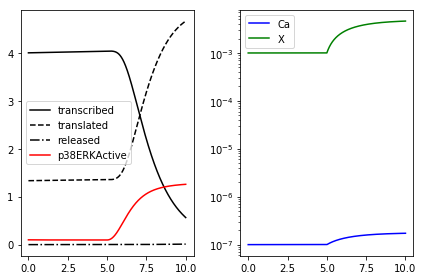

In [503]:
plt.subplot(1,2,1)
plt.plot(ts, ys[:,0],'k',label="transcribed")
plt.plot(ts, ys[:,1],'k--',label="translated")
plt.plot(ts, ys[:,2],'k-.',label="released")
plt.plot(ts, ys[:,3],'r',label="p38ERKActive")
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(ts, ys[:,4],'b',label="Ca")
plt.plot(ts, ys[:,5],'g',label="X")
plt.yscale('log')
plt.legend(loc=0)
plt.tight_layout()
plt.gcf().savefig("TNF_time.png",dpi=300)

#### Give tests

In [497]:
## Common
cases = dict()
class empty:pass
y0s = [transcribedTNF, translatedTNF,releasedTNF,activep38ERK,Ca_basal,X_basal]



# noATP (don't have P2X model, so just assume t>tlag will activate channel )
tActive = 1e9
case = empty()
case.ts = ts
params['iCa']=1e-4 # pA
case.ys = odeint(dTNFdt_CaRelease_p38ERK_P2X,y0s,ts,
            args=(rTranscribe, rDegrade,tActive,params))
cases['noATP']=case

# w ATP
tActive = 5
params['iCa']=1e-4 # pA
case = empty()
case.ts = ts
case.ys = odeint(dTNFdt_CaRelease_p38ERK_P2X,y0s,ts,
            args=(rTranscribe, rDegrade,tActive,params))
cases['wATP']=case

# 'remove' extracellular Ca via EGTA as in TNFa paper
tActive = 5
params['iCa']=1e-7 # pA
case = empty()
case.ts = ts
case.ys = odeint(dTNFdt_CaRelease_p38ERK_P2X,y0s,ts,
            args=(rTranscribe, rDegrade,tActive,params))
cases['wATP_noCa']=case

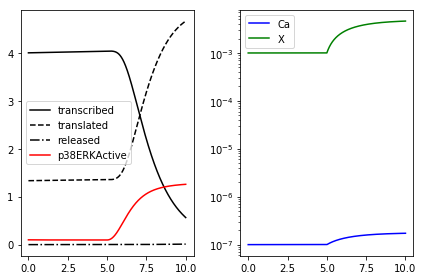

In [498]:
case = cases['wATP_noCa']
ys = case.ys
plt.subplot(1,2,1)
plt.plot(ts, ys[:,0],'k',label="transcribed")
plt.plot(ts, ys[:,1],'k--',label="translated")
plt.plot(ts, ys[:,2],'k-.',label="released")
plt.plot(ts, ys[:,3],'r',label="p38ERKActive")
plt.legend(loc=0)

plt.subplot(1,2,2)
plt.plot(ts, ys[:,4],'b',label="Ca")
plt.plot(ts, ys[:,5],'g',label="X")
plt.yscale('log')
plt.legend(loc=0)
plt.tight_layout()

In [499]:
def DoBarPlot(cases,label="released",index=2):
    
    nItems  =len(cases.keys())
    vals = np.zeros( nItems )
    for i,key in enumerate(cases.iterkeys()):
        # get point
        case= cases[key]
        ys = case.ys
        tf = case.ts[-1]
        # get last time point 
        ysReleased = ys[:,index]
        yVal = ysReleased[-1]
        vals[i]=yVal
    print vals


    fig, ax = plt.subplots()
    ind = range(nItems)
    ax.bar(range(nItems),vals)
    #ax.set_ylim([-0.1,2])
    ax.set_xticks(ind )
    ax.set_xticklabels(cases.keys())
    ax.set_title("%s after %3.1f"%(label,tf))
    


[ 0.01032414  1.74522703  0.002027  ]
[  1.72623004e-07   7.27230044e-05   1.00000000e-07]


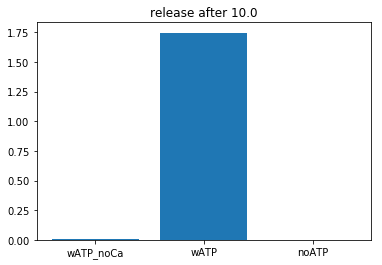

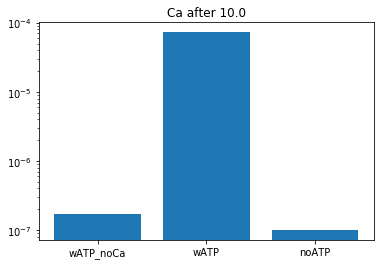

In [502]:
# TNF release
DoBarPlot(cases,label="release",index=2)
plt.gcf().savefig("TNF_release.png",dpi=300)

# Ca
DoBarPlot(cases,label="Ca",index=4)
plt.yscale('log')
